In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [22]:
with open("Cleaned_LoanData.csv", "r", encoding='utf-8') as f:
    line_count = sum(1 for line in f)
print("Lines in file (including header):", line_count)


Lines in file (including header): 290263


In [23]:
df = pd.read_csv("Cleaned_LoanData.csv", sep=None, engine='python', encoding='utf-8')
print(df.shape)


(290262, 42)


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290262 entries, 0 to 290261
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CreditScore                 290262 non-null  int64  
 1   FirstPaymentDate            290262 non-null  object 
 2   FirstTimeHomebuyer          290262 non-null  float64
 3   MaturityDate                290262 non-null  object 
 4   MIP                         290262 non-null  int64  
 5   Units                       290262 non-null  int64  
 6   OCLTV                       290262 non-null  int64  
 7   DTI                         290262 non-null  int64  
 8   OrigUPB                     290262 non-null  int64  
 9   LTV                         290262 non-null  int64  
 10  OrigInterestRate            290262 non-null  float64
 11  PropertyState               290262 non-null  object 
 12  OrigLoanTerm                290262 non-null  int64  
 13  NumBorrowers  

In [25]:
# Drop leaky features
leaky_features = ['EverDelinquent', 'DelinquencyCategory_1', 'DelinquencyCategory_0', 'MonthsDelinquent']
df.drop(columns=leaky_features, inplace=True)

In [26]:
# Define target and features
X = df.drop(columns='DelinquencyFlag')
y = df['DelinquencyFlag']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [27]:
# Scale and fit the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate on train and test
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9460
Test Accuracy: 0.9454


In [28]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Sample 20% of training data for faster tuning
X_sampled, _, y_sampled, _ = train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42)

# Simplified grid: only L2 regularization with varying strength
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10]
}

# Grid Search with 3-fold CV and parallel jobs
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit grid search on sampled training data
grid_search.fit(X_sampled, y_sampled)

# Save best model
best_model = grid_search.best_estimator_

# Output best parameters
print(" Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best Parameters: {'logreg__C': 1}


In [29]:
# Retrain best model on the full training data
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Train Accuracy: 0.9460098445796674
Test Accuracy: 0.9454119511480888

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     46585
           1       0.95      0.76      0.85     11468

    accuracy                           0.95     58053
   macro avg       0.95      0.88      0.91     58053
weighted avg       0.95      0.95      0.94     58053

Confusion Matrix:
 [[46156   429]
 [ 2740  8728]]


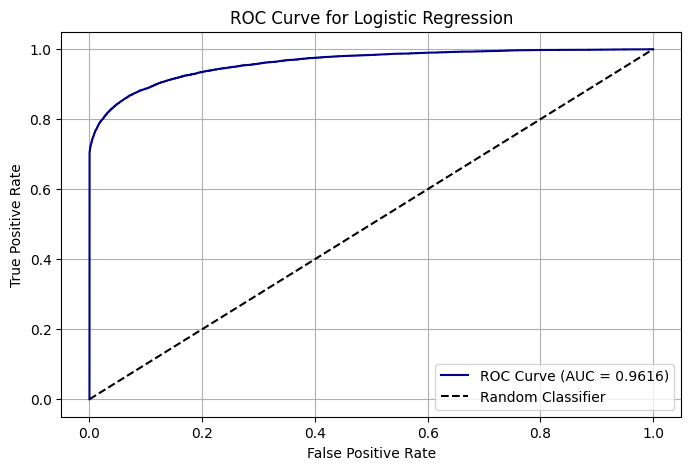

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probability predictions
y_proba = best_model.predict_proba(X_test)[:, 1]

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()
